<a href="https://colab.research.google.com/github/2023Shoggy/M.Sc-Thesis/blob/main/MSCTHESIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTRO

In [1]:
!pip install patool opencv-python pydot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 3.2 MB/s eta 0:00:00


In [2]:
# Load the TensorBoard notebook extension
#%load_ext tensorboard

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import cv2
import patoolib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Input, UpSampling2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape, Lambda, GlobalAveragePooling2D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc

print ('All the required libraries have been imported')


All the required libraries have been imported


In [5]:
# Extract the .rar file
patoolib.extract_archive("/content/drive/MyDrive/Dataset of Mammography with Benign Malignant Breast Masses.rar", outdir="datasets")

INFO patool: Extracting /content/drive/MyDrive/Dataset of Mammography with Benign Malignant Breast Masses.rar ...
INFO:patool:Extracting /content/drive/MyDrive/Dataset of Mammography with Benign Malignant Breast Masses.rar ...
INFO patool: ... creating output directory `datasets'.
INFO:patool:... creating output directory `datasets'.
INFO patool: running /usr/bin/unrar x -- "/content/drive/MyDrive/Dataset of Mammography with Benign Malignant Breast Masses.rar"
INFO:patool:running /usr/bin/unrar x -- "/content/drive/MyDrive/Dataset of Mammography with Benign Malignant Breast Masses.rar"
INFO patool:     with cwd='datasets', input=''
INFO:patool:    with cwd='datasets', input=''
INFO patool: ... /content/drive/MyDrive/Dataset of Mammography with Benign Malignant Breast Masses.rar extracted to `datasets'.
INFO:patool:... /content/drive/MyDrive/Dataset of Mammography with Benign Malignant Breast Masses.rar extracted to `datasets'.


'datasets'

In [6]:
# DATA PREPROCESSING
# The dataset (images) are preprocessed by setting the paths to the dataset,
# resizing, normalising and splitting them into train and test dataset.

benign_path = "./datasets/Dataset of Mammography with Benign Malignant Breast Masses/MIAS Dataset/Benign Masses"
malignant_path = "./datasets/Dataset of Mammography with Benign Malignant Breast Masses/MIAS Dataset/Malignant Masses"
images = []
labels = []


# A function 'load images from folder" is created to load load images from a directory with reduced size
def load_images_from_folder(folder, label):
    count = 0
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128, 128))  # reducing image size from 227*227
            img = img / 255.0  # images are Normalised
            images.append(img)
            labels.append(label)
            count += 1
    return count

# Reload the images after reducing the size
images = []
labels = []

# Load and count the number of benign images
benign_count = load_images_from_folder(benign_path, 0)
print(f" The number of benign images: {benign_count}")


# Load and count the number of malignant images
malignant_count = load_images_from_folder(malignant_path, 1)
print(f"The number of malignant images: {malignant_count}")


# The lists are Converted to numpy arrays
images = np.array(images, dtype='float32') # Float32 is used to reduce memory usage
labels = np.array(labels)


# The images are reshaped to include the channel dimension
images = images.reshape(-1, 128, 128, 1)

 The number of benign images: 2376
The number of malignant images: 1440


In [7]:
# SPLITTING AND TRAINING THE DATASET
# The dataset is split into training and testing sets using the train_test_split function
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# Data augmentation to reduce overfitting and enhance model learning
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [8]:
# Function to display some sample images from the dataset
def display_sample_images(images, labels, sample_size=8):
    plt.figure(figsize=(10, 10))
    for i in range(sample_size):
        plt.subplot(1, sample_size, i+1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')
        plt.title('Malignant' if labels[i] == 1 else 'Benign')
        plt.axis('off')
    plt.show()

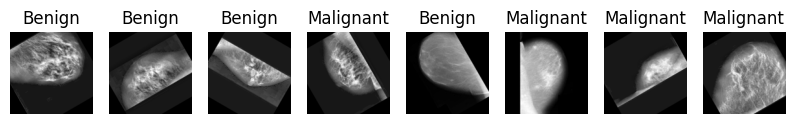

In [9]:
display_sample_images(X_train, y_train)

## Project Title: Anomaly Detection in Mammography using CNN and Autoencoders

### Research Questions
Investigate the features of Convolutional Autoencoder (CAE) and Variational Autoencoder (VAE) vs DenseNets (CNN), How does different feature extraction techniques impact their performance in identifying anomalies in mammographic images?
Comparing the efficacy of Convolutional Autoencoder (CAE) and Variational Autoencoder (VAE) vs DenseNets (CNN), which of them is the most accurate in identifying anomalies in mammography images?

### Project Objectives
The primary objective of this project is to develop and evaluate advanced machine-learning models for detecting anomalies in mammography images. I will compare the performance of convolutional autoencoders (CAE) and variational autoencoders (VAE) against DenseNets (CNN) in identifying these anomalies to determine which model provides higher accuracy and reliability in anomaly detection. Another goal is to assess the computational efficiency and scalability of each model when applied to large datasets of mammography images. Additionally, the project intends to explore the interpretability of the model's outputs to ensure they can be effectively used in clinical settings. The project will provide insights into the strengths and weaknesses of each approach, and the findings from this report will contribute to improving the early detection of breast cancer through more accurate and efficient anomaly detection methods.

### Summary of project and background
This project focuses on the application of advanced machine learning techniques to detect anomalies in mammography images, which is crucial for early breast cancer detection. The research compares the efficacy of Convolutional Autoencoders (CAE) and Variational Autoencoders (VAE) with DenseNets (CNN) in identifying these anomalies. Mammography is a widely used screening tool for breast cancer, but the interpretation of images can be challenging and prone to human error. By leveraging deep learning models, the project aims to enhance the accuracy  and reliability of anomaly detection, potentially leading to better clinical outcomes. The background of this project lies in the need for more effective and automated methods to assist radiologists in diagnosing breast cancer. The use of CAE, VAE, and CNN models represents a cutting-edge approach in the field of medical image analysis. This research will contribute to the ongoing efforts to improve breast cancer screening and diagnosis through technological advancements.

## Convolutional Autoencoder (CAE)


In [10]:
# THE CONVOLUTIONAL AUTOENCODER (CAE)

# The input for the CAE model is defined
input_image = Input(shape=(128, 128, 1))

# Building the layers of the encoder
# Using Convolutional layers (to observe features and learn patterns) with 32, 16 and 8 filters
# And pooling layers (to reduce the image dimension) to decrease the size of the images in height and width by a factor of 2
# Padding is 'same' to ensure that the output size is same as the input size
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_image)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

# final convolutional layer which further decreases the image size by a factor of 2 to produce the output (compressed image)
encoded = MaxPooling2D((2, 2), padding='same')(x)


# Building the layers of the decoder
# Using Convolutional layers (to observe features and learn patterns) with 8, 16 and 32 filters
# And upsampling layers (to upscale image resolution) to increase the size of the images in height and width by a factor of 2
# Padding is 'same' to ensure that the output size is same as the input size
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

# final convolutional layer using a single filter to produce the output (reconstructed image)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


# Compiling the CAE model using the Adam optimiser
autoencoder = Model(input_image, decoded)
autoencoder.compile(optimizer= 'Adam', loss='binary_crossentropy')
autoencoder.summary()


# To ensure both input shape and output shapes are the same
print("Input shape:", X_train.shape)
print("Output shape:", autoencoder.output.shape)


# Define early stopping callback to track if there are no changes in Val_loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Both the benign and malignant images are used in training the CAE model
history = autoencoder.fit(X_train, X_train,
                          #epochs=20,
                          #epochs=5,
                          epochs=50,
                          batch_size=32,
                          validation_split=0.3,
                          callbacks=[early_stopping])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 32, 32, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 1)         │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,785 (49.94 KB)

 Trainable params: 12,785 (49.94 KB)

 Non-trainable params: 0 (0.00 B)

Input shape: (2671, 128, 128, 1)
Output shape: (None, 128, 128, 1)
Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - loss: 0.6178 - val_loss: 0.3794
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3712 - val_loss: 0.3588
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3577 - val_loss: 0.3542
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3549 - val_loss: 0.3521
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3508 - val_loss: 0.3509
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3514 - val_loss: 0.3500
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3537 - val_loss: 0.3495
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3500 - val_loss: 0.3490
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3470 - val_loss: 0.3488
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3500 - val_loss: 0.3483
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3452 - val_loss: 0.

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


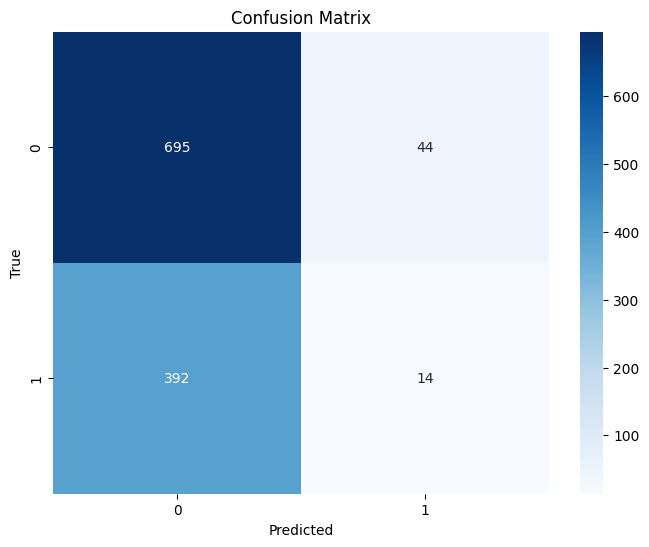

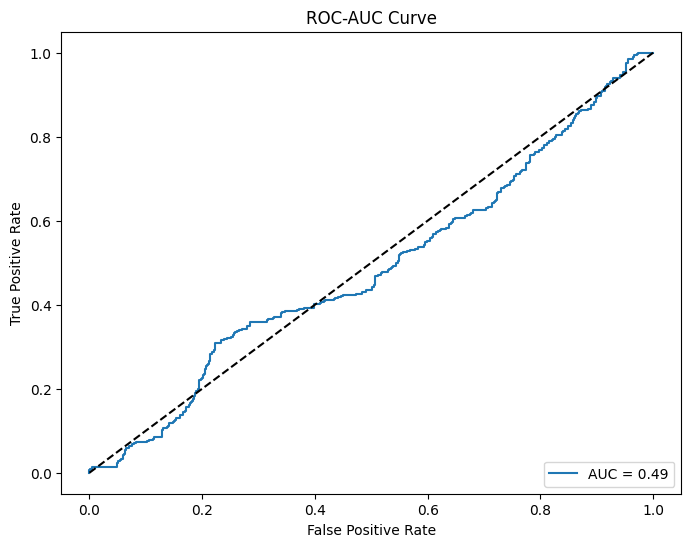

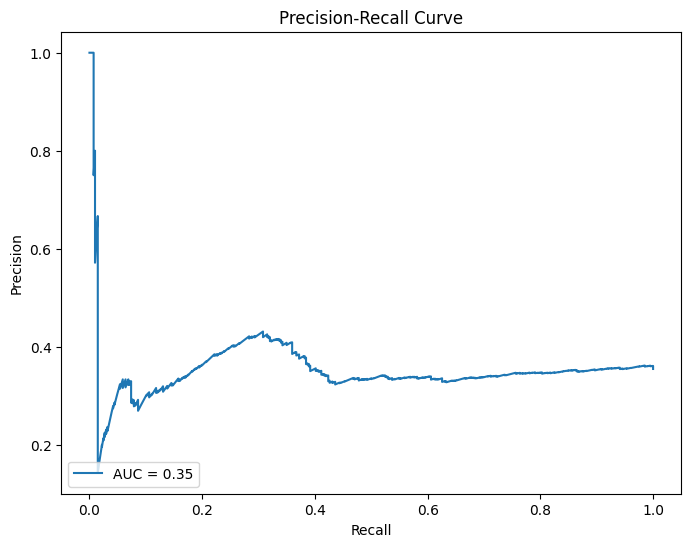

Classification Report:
               precision    recall  f1-score   support

      Benign       0.64      0.94      0.76       739
   Malignant       0.24      0.03      0.06       406

    accuracy                           0.62      1145
   macro avg       0.44      0.49      0.41      1145
weighted avg       0.50      0.62      0.51      1145

Accuracy: 61.92%
Precision: 0.24
Recall: 0.03
F1 Score: 0.06
ROC-AUC Score: 0.49


In [11]:
# EVALUATING THE CAE

# Predict reconstructed images
X_test_pred = autoencoder.predict(X_test)

# Calculate reconstruction error
reconstruction_error = np.mean(np.square(X_test - X_test_pred), axis=(1, 2, 3))

# Determine the threshold for anomaly detection by setting error percentile threshold to 95
threshold = np.percentile(reconstruction_error, 95)

# using the reconstruction error for anomaly classification
y_pred = (reconstruction_error > threshold).astype(int)

# VISUALISATION OF THE EVALUATION METRICS
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_error)
roc_auc = roc_auc_score(y_test, reconstruction_error)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, reconstruction_error)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=['Benign', 'Malignant'])
print("Classification Report:\n", class_report)

# Precision, Recall, F1-Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")

## Variational Autoencoder (VAE)

In [12]:
# THE VARIATIONAL AUTOENCODER (VAE)
# The input for the VAE model is defined
input_image = Input(shape=(128, 128, 1))


# Building the layers of the encoder
# Using Convolutional layers (to observe features and learn patterns) with 32, 64 and 128 filters
# And pooling layers (to reduce the image dimension) to decrease the size of the images in height and width by a factor of 2
# Padding is 'same' to ensure that the output size is same as the input size
# the activation 'relu' introduces nonlinearity
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_image)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Flatten layer to convert the 3D output to 1D for the dense layer
x = Flatten()(x)

# the fully connected dense layer with 256 neurons and 'relu' activation for nonlinearity
x = Dense(256, activation='relu')(x)

# Dropout layer for regularisation to prevent overfitting
x = Dropout(0.4)(x)

# Defining the latent space
# size of the latent space
latent_dim = 128
# mean vector of the latent variables
z_mean = Dense(latent_dim)(x)
# log variance vector of the latent variables
z_log_var = Dense(latent_dim)(x)

# defining the sampling function to same points from the latent space for smooth and continuous learning
def sampling(latentspace_parameters):
    z_mean, z_log_var = latentspace_parameters
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) # For stochasticity in sampling
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# the latent variable with lambda layer
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


# Building the layers of the decoder
# Using Convolutional layers (to observe features and learn patterns) with 128, 64 and 32 filters
# And upsampling layers (to upscale image resolution) to increase the size of the images in height and width by a factor of 2
# Padding is 'same' to ensure that the output size is same as the input size
# the activation 'relu' introduces nonlinearity

# Input layer for the 1D vector size (the latent_dim of 128)
decoder_input = Input(shape=(latent_dim,))
# The fully connected dense layer for upscaling the latent_dim
x = Dense(16*16*128, activation='relu')(decoder_input)
# converts 1D output into 3D tensor
x = Reshape((16, 16, 128))(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

# final convolutional layer using a single filter to produce the output (reconstructed image)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


# DEFINING THE VAE MODEL
encoder = Model(input_image, [z_mean, z_log_var, z], name='Encoder')
decoder = Model(decoder_input, decoded, name='Decoder')
output_image = decoder(encoder(input_image)[2])
vae = Model(input_image, output_image, name='VAE')

# Define the combined (reconstruction and Kl divergence) VAE loss function for training the model
def vae_loss(input_image, output_image, z_mean, z_log_var):
    reconstruction_loss = binary_crossentropy(K.flatten(input_image), K.flatten(output_image)) * 128 * 128
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(reconstruction_loss + kl_loss)

# Compiling the VAE model with the custom loss function (custom_vae_loss) and adam optimiser
def custom_vae_loss(y_true, y_pred):
    z_mean, z_log_var = encoder(y_true)[0], encoder(y_true)[1]
    return vae_loss(y_true, y_pred, z_mean, z_log_var)

vae.compile(optimizer=Adam(learning_rate=0.001), loss=custom_vae_loss)
vae.summary()

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.3
)

# Define early stopping callback to track if there are no changes in Val_loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



# Both the benign and malignant images are used in training the VAE mode
history = vae.fit(datagen.flow(X_train, X_train, batch_size=32, subset='training'),
                  #epochs=20,
                  #epochs=5,
                  epochs=50,
                  validation_data=datagen.flow(X_train, X_train, batch_size=32, subset='validation'),
                  callbacks=[early_stopping])



Model: "VAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder (Functional)                 │ [(None, 128), (None, 128),  │       8,547,328 │
│                                      │ (None, 128)]                │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder (Functional)                 │ (None, 128, 128, 1)         │       4,467,201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,014,529 (49.65 MB)

 Trainable params: 13,014,529 (49.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


59/59 ━━━━━━━━━━━━━━━━━━━━ 30s 293ms/step - loss: 9152.5400 - val_loss: 7822.1519
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 7702.9717 - val_loss: 7704.0693
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 7574.1196 - val_loss: 7489.6035
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 7475.5181 - val_loss: 7456.7705
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 7403.1338 - val_loss: 7393.6577
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 7359.6045 - val_loss: 7349.5083
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 7372.3076 - val_loss: 7353.4102
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 7346.6309 - val_loss: 7353.7114
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 7331.5610 - val_loss: 7342.2593
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 7306.9600 - val_loss: 7269.8364
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 7293.9380 - val_loss: 7302.8604
Epoch 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Classification Report:
               precision    recall  f1-score   support

      Benign       0.65      0.95      0.77       739
   Malignant       0.36      0.05      0.09       406

    accuracy                           0.63      1145
   macro avg       0.50      0.50      0.43      1145
weighted avg       0.55      0.63      0.53      1145

Accuracy: 63.14%
Precision: 0.36
Recall: 0.05
F1 Score: 0.09
ROC-AUC Score: 0.55


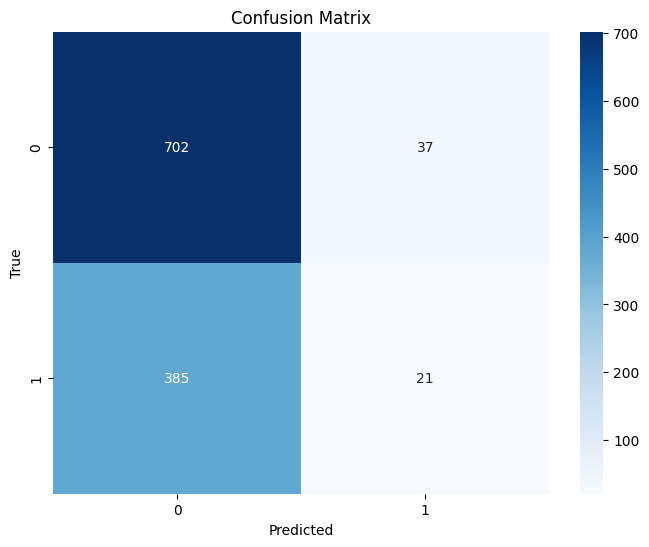

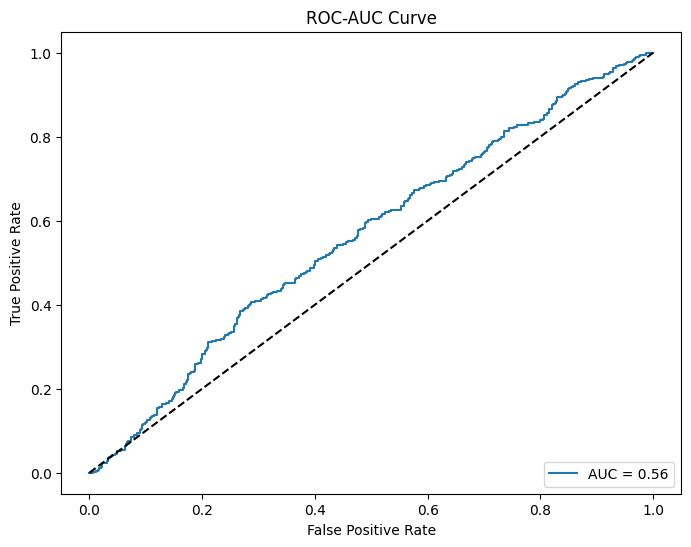

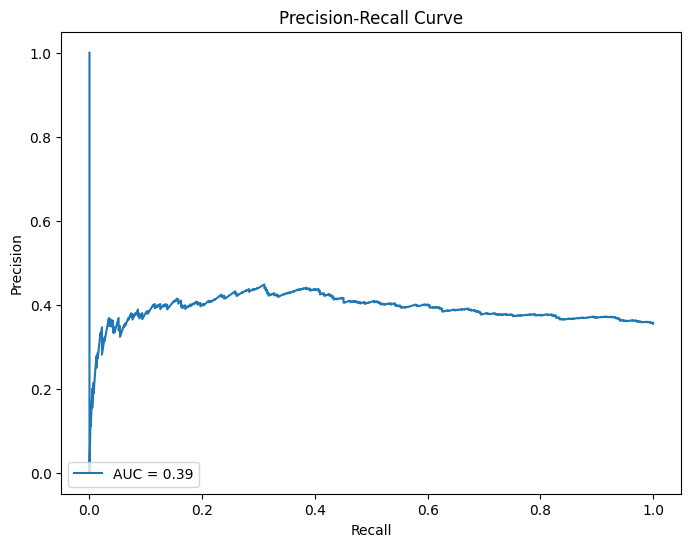

In [25]:
# EVALUATING THE VAE

# Predict the reconstructed images
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_error = np.mean(np.square(X_test - X_test_pred), axis=(1, 2, 3))

# Determine the threshold for anomaly detection by setting error percentile threshold to 95
threshold = np.percentile(reconstruction_error, 95)

# using the reconstruction error for anomaly classification
y_pred = (reconstruction_error > threshold).astype(int)

# VISUALISATION OF THE EVALUATION METRICS

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=['Benign', 'Malignant'])
print("Classification Report:\n", class_report)

# Precision, Recall, F1-Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_error)
roc_auc = roc_auc_score(y_test, reconstruction_error)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, reconstruction_error)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()



In [14]:
#%tensorboard --logdir logs/vae

## DenseNets (CNN)

In [15]:
# THE DENSENET MODEL

# Function to convert grayscale images to RGB (suitable for pretained models like densenet)
def convert_images(images):
    # Convert to RGB by duplicating the single channel
    images_rgb = np.repeat(images, 3, axis=-1)
    # Resizing the images to 128x128
    images_rgb_resized = tf.image.resize(images_rgb, [128, 128])
    return images_rgb_resized

# Image preprocessing to convert the dataset to rgb using the defined convert_images function
X_train_rgb = convert_images(X_train)
X_test_rgb = convert_images(X_test)

# Defining the DenseNet model

# input layer showing it is in Rgb
input_tensor = Input(shape=(128, 128, 3))
# The densenet121 architecture is used as the base model with pretrained weights from imagenet
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_tensor)

x = base_model.output
x = GlobalAveragePooling2D()(x) # reduce the dimension of the images to 1D and prevents overfitting
x = Dense(256, activation='relu')(x) # fully connected dense layer with 256 neurons
predictions = Dense(1, activation='sigmoid')(x) # single unit of output layer

# densenet model definition
model = Model(inputs=base_model.input, outputs=predictions)

# Freezing  the layers of the base model to ensure that only added layers will be updated
for layer in base_model.layers:
    layer.trainable = False

# Compiling the Densenet model using Adam optimiser
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Define early stopping callback to track if there are no changes in Val_loss
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Both the benign and malignant images are used in training the VAE model
history = model.fit(X_train_rgb, y_train,
                    #epochs=20,
                    #epochs=5,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test_rgb, y_test),
                    callbacks=[early_stopping])


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 134, 134, 3)    │              0 │ input_layer_3[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 32, 32, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 32, 32, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 32, 32, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 55s 367ms/step - accuracy: 0.6288 - loss: 0.7561 - val_accuracy: 0.7083 - val_loss: 0.5903
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7656 - loss: 0.4761 - val_accuracy: 0.8157 - val_loss: 0.4156
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8356 - loss: 0.3757 - val_accuracy: 0.8690 - val_loss: 0.3295
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9064 - loss: 0.2612 - val_accuracy: 0.8725 - val_loss: 0.2810
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9169 - loss: 0.2141 - val_accuracy: 0.8638 - val_loss: 0.2956
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9342 - loss: 0.1865 - val_accuracy: 0.8900 - val_loss: 0.2412
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9511 - loss: 0.1564 - val_accuracy: 0.9205 - val_loss: 0.1985
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9853 - loss: 0.0840 - val_accuracy: 0.9249 -

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Classification Report:
               precision    recall  f1-score   support

      Benign       0.98      0.96      0.97       739
   Malignant       0.94      0.96      0.95       406

    accuracy                           0.96      1145
   macro avg       0.96      0.96      0.96      1145
weighted avg       0.96      0.96      0.96      1145

Accuracy: 96.24%
Precision: 0.94
Recall: 0.96
F1 Score: 0.95
ROC-AUC Score: 1.00
Confusion Matrix:
 [[712  27]
 [ 16 390]]


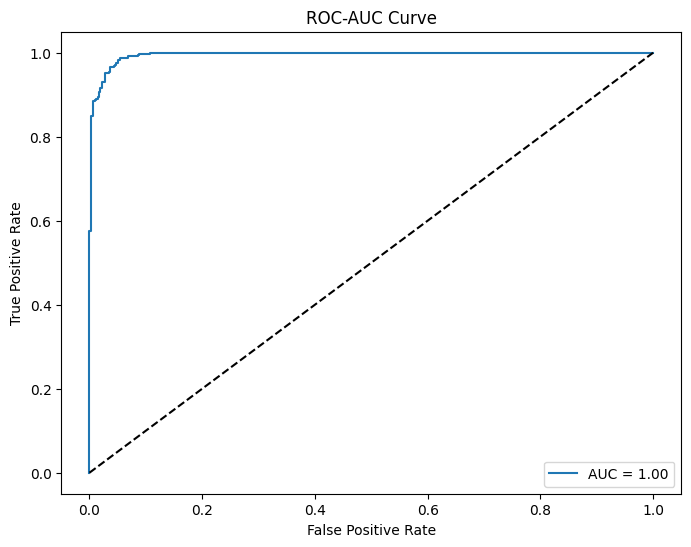

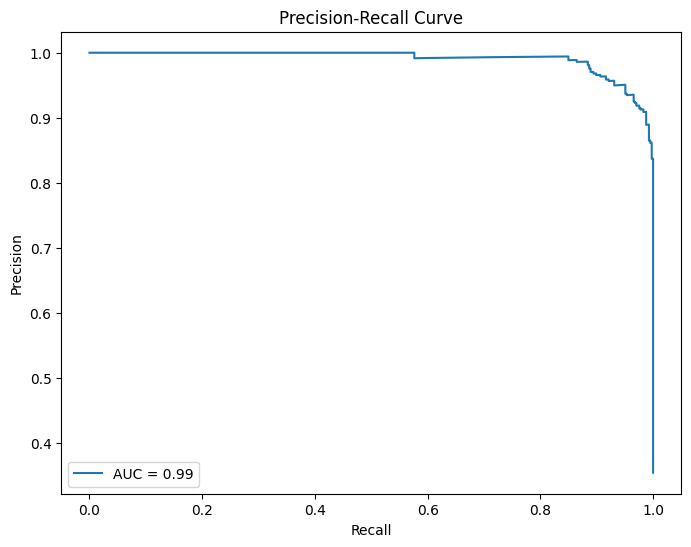

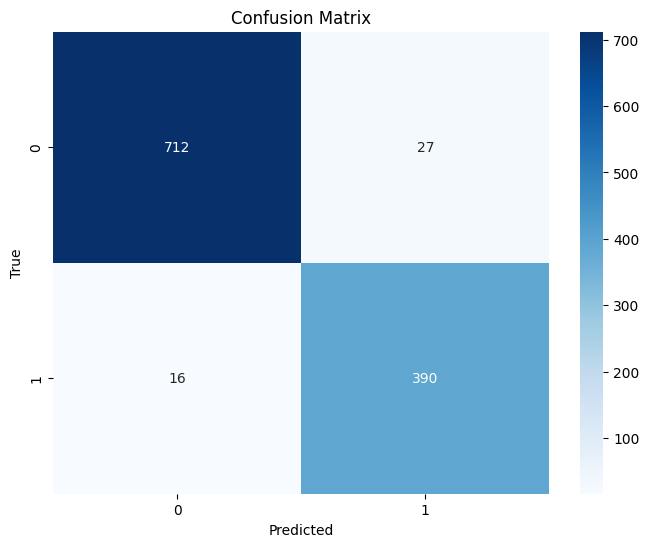

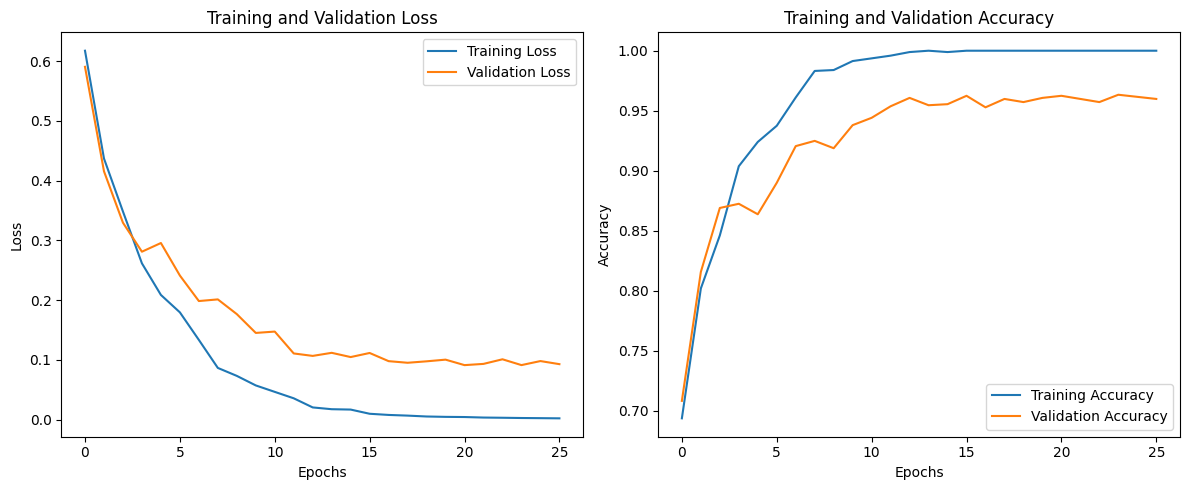

In [19]:
# EVALUATING THE DENSENET

# Predict on test data (converted images)
y_pred_prob = model.predict(X_test_rgb)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=['Benign', 'Malignant'])
print("Classification Report:\n", class_report)

# Precision, Recall, F1-Score
accuracy = accuracy_score(y_test, y_pred)
precision_val = precision_score(y_test, y_pred)
recall_val = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision_val:.2f}")
print(f"Recall: {recall_val:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print("Confusion Matrix:\n", conf_matrix)

# ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plotting Training and Validation Loss and Accuracy
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

